In [1]:
import os
import operator
import numpy as np
from typing import List
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath
import matplotlib.pyplot as plt

In [2]:
def load_dataset(path) -> List[tuple[List[str], str]]:
    result = []
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(path + '/' + file) as f:
                cluster_reading = True
                cluster = []
                outliers = []
                for line in f:
                    line = line.rstrip()
                    if len(line) > 0:
                        if not line.startswith('#'):
                            if cluster_reading:
                                cluster.append(line)
                            else:
                                outliers.append(line)
                    else:
                        cluster_reading = False
                for outlier in outliers:
                    result.append((cluster, outlier))
    return result

In [3]:
def compute_accuracy(dataset, sim_fun):
    similarities = {}
    correct_guesses = 0
    total_guesses = 0
    for sample in dataset:
        cluster, outlier = sample
        items = cluster + [outlier]
        compactness = {}
        for item1 in items:
            compactness[item1] = 0.0
            for item2 in items:
                if item1 != item2:
                    compactness[item1] += sim_fun(item1, item2)
        least_compact = sorted(compactness.items(), key=operator.itemgetter(1))[0][0]
        if least_compact == outlier:
            correct_guesses += 1
        else:
            print(f"Failed {cluster} / {outlier}")
        total_guesses += 1
    return correct_guesses / total_guesses

In [4]:
wv = KeyedVectors.load_word2vec_format('fasttext-cc100-d100-w3-min10.vectors', binary=False)

In [5]:
wv.similarity('шчанюк', 'сабака')

0.18425144

In [6]:
eval_dataset = load_dataset('evaluation/outlier-detection')

In [7]:
compute_accuracy(eval_dataset, lambda w1, w2: wv.similarity(w1, w2))

Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / вёска
Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / мэр
Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / транспарт
Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / турыст
Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / мапа
Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / кава
Failed ['вуліца', 'дом', 'парк', 'плошча', 'праспект', 'сквер', 'завулак', 'бульвар'] / крыж
Failed ['галава', 'рука', 'нага', 'тулава', 'шыя', 'палец', 'спіна', 'плячо'] / медыцына
Failed ['галава', 'рука', 'нага', 'тулава', 'шыя', 'палец', 'спіна', 'плячо'] / мышца
Failed ['галава', 'рука', 'нага', 'тулава', 'шыя', 'палец', 'спіна', 'плячо'] / шапка
Failed ['галава', 'рука', 'нага', 'тулава', 'шыя', 'палец', 'спіна', 'плячо'] / а

0.45977011494252873

Performance is very low and quick look at similar words proves that. Here are most similar words for a frequent word and for a rare word.

In [16]:
wv.most_similar('беларусь', topn=20)

[('беларуськалій', 0.9866620898246765),
 ('беларусафоб', 0.9622538685798645),
 ('беларусафіл', 0.9578112363815308),
 ('беларусіст', 0.9456225633621216),
 ('беларушчына', 0.9413305521011353),
 ('беларусістка', 0.93881756067276),
 ('беларусьфільм', 0.9384164214134216),
 ('беларукі', 0.937929630279541),
 ('беларусбанк', 0.9344540238380432),
 ('беларусізм', 0.9328805804252625),
 ('беларус', 0.928290069103241),
 ('беларусізатар', 0.9200881719589233),
 ('беларусізацыя', 0.911881148815155),
 ('беларусачка', 0.911642849445343),
 ('беларусафобскі', 0.9106850624084473),
 ('беларусазнаўчы', 0.907381534576416),
 ('беларусазнаўства', 0.9061743021011353),
 ('беларусазнавец', 0.9032054543495178),
 ('беларучка', 0.900594174861908),
 ('беларусістыка', 0.9005021452903748)]

In [17]:
wv.most_similar('пітон', topn=20)

[('піон', 0.8844119310379028),
 ('хітон', 0.881405770778656),
 ('жэтон', 0.8684950470924377),
 ('піжон', 0.8652530312538147),
 ('бутон', 0.8564432859420776),
 ('кетон', 0.8408244848251343),
 ('бітон', 0.8237384557723999),
 ('мутон', 0.820688784122467),
 ('лептон', 0.8185049295425415),
 ('фельетон', 0.8134161829948425),
 ('пілон', 0.8121647834777832),
 ('пірон', 0.8002453446388245),
 ('батон', 0.7960746884346008),
 ('плутон', 0.7929946184158325),
 ('чон', 0.7907909750938416),
 ('бурдон', 0.7907209396362305),
 ('піцер', 0.7886410355567932),
 ('шашон', 0.7847684025764465),
 ('тон', 0.7799882292747498),
 ('фаэтон', 0.7742140293121338)]

Let's check whether we have correlation between frequency of a word and its average similarity to another word.

In [9]:
vocab_size = len(wv.index_to_key)
pairs = [(np.random.randint(vocab_size), np.random.randint(vocab_size)) for _ in range(1000)]
similarities = [wv.similarity(wv.index_to_key[p[0]], wv.index_to_key[p[1]]) for p in pairs]

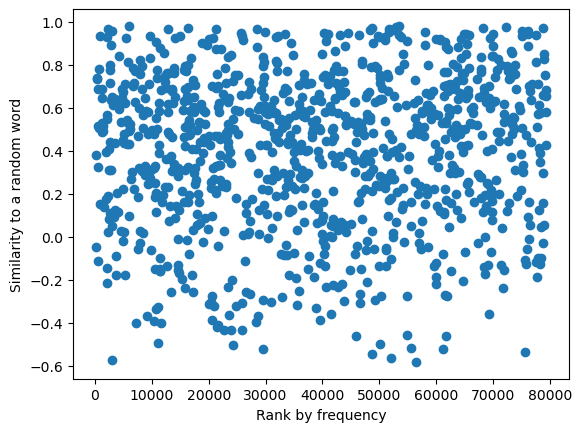

In [10]:
plt.scatter([p[0] for p in pairs], similarities)
plt.xlabel('Rank by frequency')
plt.ylabel('Similarity to a random word')
plt.show()

In [19]:
np.mean(np.abs(wv.get_vector('пітон')))

0.8791156

In [21]:
np.mean(np.abs(wv.get_vector('беларусь')))

4.245037

In [23]:
coord_abs_values = [np.mean(np.abs(wv.get_vector(word))) for word in wv.index_to_key]

Text(0, 0.5, 'Mean absolute coordinate value of embedding')

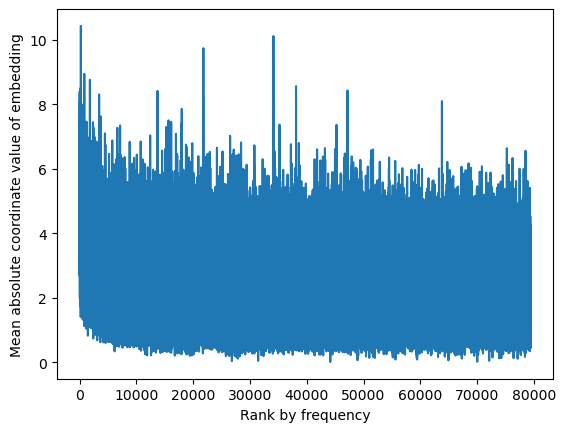

In [24]:
plt.plot(coord_abs_values)
plt.xlabel('Rank by frequency')
plt.ylabel('Mean absolute coordinate value of embedding')

Conclusion: fasttext results in simlarities based on syntax rather than semantics. Word embedding is mostly unaffected by the frequency of this word.